Implementation of a quantum algorithm designed to check system specification consistency, developed by Mohammed Zidan, Ahmed M. Eisa, Montasir Qasymeh, and Mahmoud A. Ismail Shoman. [ [1] ]

[1]: https://ieeexplore-ieee-org.proxy.library.carleton.ca/document/10485497 "A Quantum Algorithm for System Specifications Verification"

In [288]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
%matplotlib inline

Table 1. Truth table example for a consistent system with 3 variables and 2 function oracles (F1 = !X0 X2, F2 = !X0 !X1)
| X0 | X1 | X2 | F1  | F2  | Bool |
|----|----|----|----|----|----|
|  0 |  0 |  0 |  0  |  1  | False |
|  0 |  0 |  1 |  1  |  1  | True |
|  0 |  1 |  0 |  0  |  0  | False |
|  0 |  1 |  1 |  1  |  0  | False |
|  1 |  0 |  0 |  0  |  0  | False |
|  1 |  0 |  1 |  0  |  0  | False |
|  1 |  1 |  0 |  0  |  0  | False |
|  1 |  1 |  1 |  0  |  0  | False |

Table 2. Truth table example for an inconsistent system with 3 variables and 2 function oracles (F1 = X0 !X2, F2 = !X0 !X1)
| X0 | X1 | X2 | F1  | F2  | Bool |
|----|----|----|----|----|----|
|  0 |  0 |  0 |  0  |  1  | False |
|  0 |  0 |  1 |  0  |  1  | False |
|  0 |  1 |  0 |  0  |  0  | False |
|  0 |  1 |  1 |  0  |  0  | False |
|  1 |  0 |  0 |  1  |  0  | False |
|  1 |  0 |  1 |  0  |  0  | False |
|  1 |  1 |  0 |  1  |  0  | False |
|  1 |  1 |  1 |  0  |  0  | False |


In [289]:
#Table 1 representation
consistent_system = {
    "terms" : ["0x1", "00x"],
    "var_count" : 3,
    "function_count" : 2
}

#Table 2 representation
inconsistent_system = {
    "terms" : ["1x0", "00x"],
    "var_count" : 3,
    "function_count" : 2
}

In [290]:
def init__original_circuit(var_count: int, function_count: int) -> QuantumCircuit:
    """
    Function: init_original_circuit
    Params: var_count(number of variables in system), function_count(number of functions/oracles in system)
    Return: QuantumCircuit - Circuit constructed based on parameters provided

    This function initializes the original circuit with all the registers, and sets the unknown qubits X0,X1,..Xn in a state of superposition
    """
    qc_original = QuantumCircuit()

    qc_original.add_register(QuantumRegister(var_count, name="X")) #Creates register with number of qubits n defined in system
    qc_original.h(qc_original.qregs[0]) #Adds Hadamard gates to add qubits in register X

    for i in range(function_count): #Loop that creates a register for every function oracle
        reg_name = f"F{i+1}"
        qc_original.add_register(QuantumRegister(1, name=reg_name))

    #Auxillary qubits
    qc_original.add_register(QuantumRegister(1, name="aux")) 
    qc_original.add_register(QuantumRegister(1, name="a1")) 
    qc_original.add_register(QuantumRegister(1, name="a2"))
 
    #qc_original.draw("mpl")

    return qc_original

In [291]:
def apply_oracles(qc_original: QuantumCircuit, terms, function_count) -> QuantumCircuit:
    """
    Based on the terms provided, this function will create oracles and apply them to the circuit accordingly
    """
    for i in range(function_count):
        reg_c = qc_original.qregs[0]
        reg_t = qc_original.qregs[i+1]
        term = terms[i]

        c1, c2, c_p1, c_p2 = None, None, None, None #Control 1 value, control 2 value, control 1 position, control 2 position

        for j in range(len(term)): #Determines position and value of the controls
            if term[j] != 'x':
                if c1 == None:
                    c1 = int(term[j])
                    c_p1 = j
                else:
                    c2 = int(term[j])
                    c_p2 = j

        qc_original.ccx(reg_c[c_p1], reg_c[c_p2], reg_t[0], ctrl_state=f"{c1}{c2}") #Creates oracle based on the term control values, applies it to the function as a target

    #qc_original.draw("mpl")

    return qc_original
        

In [292]:
def apply_aux_hadamard(qc_original: QuantumCircuit, function_count: int) -> QuantumCircuit:
    """
    Applies the multi-controled x gate and control hadamard gate
    """
    reg_control = []

    for i in range(function_count):
        reg_control.append(qc_original.qregs[1+i]) 

    qc_original.mcx(reg_control, qc_original.qregs[function_count+1][0])
    qc_original.ch(qc_original.qregs[function_count+1][0], qc_original.qregs[function_count+2][0])

    #qc_original.draw("mpl")

    return qc_original

In [293]:
def mirror_circuit(qc_original: QuantumCircuit) -> QuantumCircuit:
    """
    Suggested method to add mirror from: https://nbviewer.org/github/ahmedeasa/Quantum-System-Specification-Verification-Algorithm/blob/main/System_Specifications_Verfication_ST_LAB_1.ipynb
    """
    qc_mirror = qc_original.copy()
    qc_final = QuantumCircuit(2*qc_mirror.num_qubits,2*qc_mirror.num_clbits)
    qc_final.compose(qc_original,inplace=True,qubits=range(qc_mirror.num_qubits))
    qc_final.compose(qc_mirror.reverse_bits(),inplace=True,qubits=range(qc_mirror.num_qubits,2*qc_mirror.num_qubits))

    #qc_final.draw("mpl")

    return qc_final

In [294]:
def measure_aux(qc_final: QuantumCircuit, function_count: int) -> QuantumCircuit:
    a11 = qc_final.qregs[0][function_count + 4]
    a12 = qc_final.qregs[0][function_count + 5]
    a21 = qc_final.qregs[0][function_count + 6]
    a22 = qc_final.qregs[0][function_count + 7]
    
    qc_final.cx(a11, a12)
    qc_final.cx(a22, a21)

    a_measure = ClassicalRegister(4, name="measure_a")
    qc_final.add_register(a_measure)
    qc_final.measure([a22, a12, a21, a11], a_measure)

    qc_final.draw("mpl")


    return qc_final

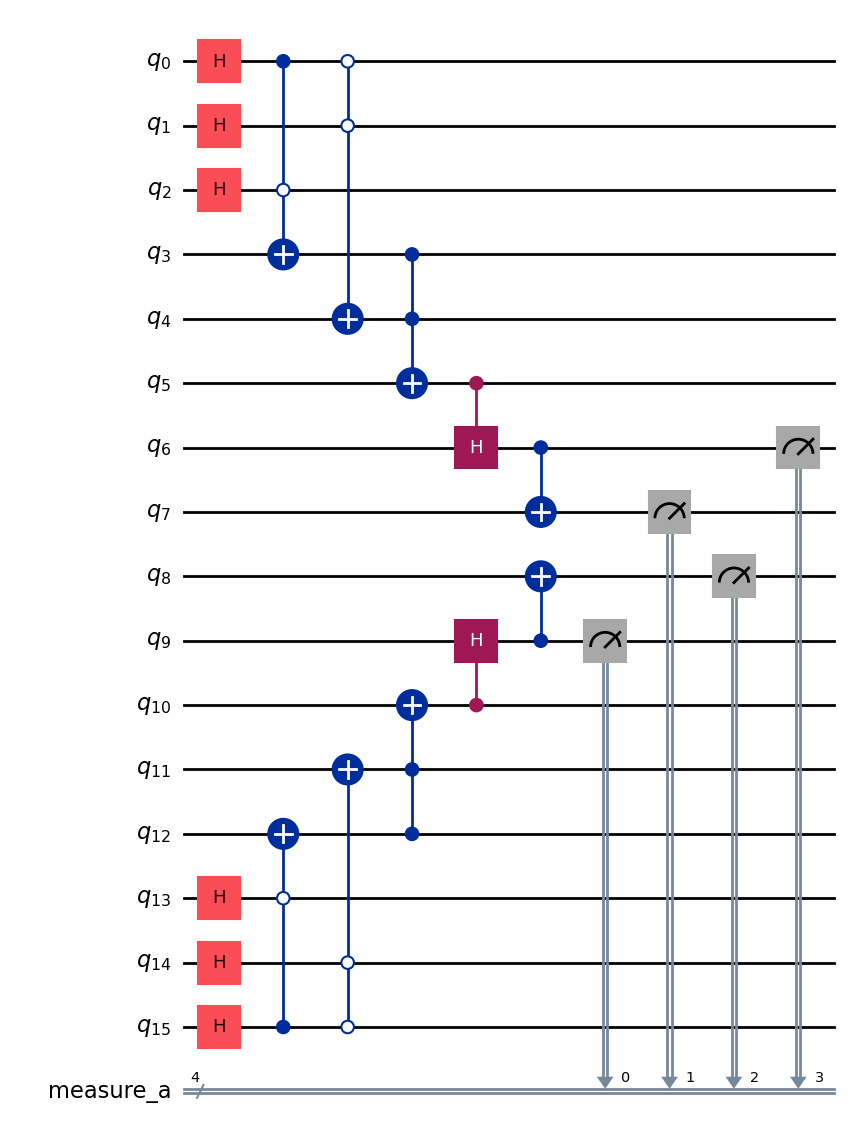

In [295]:
#Follow through of all steps in correct order

circuit = init__original_circuit(consistent_system.get("var_count"),consistent_system.get("function_count"))

apply_oracles(circuit, consistent_system.get("terms"), consistent_system.get("function_count"))

apply_aux_hadamard(circuit, consistent_system.get("function_count"))

final_circuit = mirror_circuit(circuit)

measure_aux(final_circuit, consistent_system.get("function_count"))

References

[1] M. Zidan, A. M. Eisa, M. Qasymeh, and M. A. I. Shoman, “A quantum
algorithm for system specifications verification,” IEEE Internet of Things
Journal, vol. 11, no. 14, pp. 24 775–24 794, 2024.
```